<a href="https://colab.research.google.com/github/krooner/building-recommendation-engines/blob/main/datacamp_market_basket_analysis_in_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Python 기반 장바구니 분석 (Market basket analysis)
---
from [Datacamp](https://app.datacamp.com/learn/courses/market-basket-analysis-in-python)

## Introduction
장바구니 분석이란
  - 같이 구매하는 빈도가 높은 제품들의 집합을 찾는다: 전기 (Biography)와 역사 (History) 책 / 소설과 시
  - 위의 결과를 토대로 제품을 추천한다: 전기와 역사 카테고리를 같이 둔다

적용 분야
  - 넷플릭스의 추천 엔진, 이커머스 플랫폼의 제품 추천 기능, 재고 관리 향상
  - 크로스셀링: 한 제품을 구입한 고객이 다른 제품을 추가로 구입할 수 있도록 유도하는 것
  - 업셀링: 제품을 더 많이 팔 수 있도록 함

데이터 활용

|TID|Transaction|
|---|---|
|11|fiction, biography|
|12|fiction, biography|
|13|history, biography|
|...|...|
|19|fiction, biography|
|20|fiction, biography|
|...|...|

- 장바구니 분석을 위해 Association rule을 만들고 함께 자주 구매되는 제품들을 찾는다
- 연관 규칙 (Association rule)
  - `If, then` 구조로, $\{\text{antecedent}\}\rightarrow\{\text{consequent}\}$ 형태를 나타낸다.
    - $\{\text{fiction}\}\rightarrow\{\text{biography}\}$


## 0. Download and load dataset
---
### 0.1 Connect to Google Drive

In [3]:
from google.colab import drive

drive.mount('/gdrive')
gdrive_root = "/gdrive/My\ Drive"

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


### 0.3 Import

In [4]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

!pip install wget
import wget

### 0.2 Copy dataset files from My Drive

In [ ]:
dataset_folder = gdrive_root + "/my_data/datacamp/market-basket-analysis-in-python/*.csv"
!cp $dataset_folder .

url = "https://raw.githubusercontent.com/zygmuntz/goodbooks-10k/master/ratings.csv"
wget.download(url)
url = "https://raw.githubusercontent.com/zygmuntz/goodbooks-10k/master/books.csv"
wget.download(url)

### 0.4 Load raw dataset files (.csv)

In [6]:
transactions = pd.read_csv("bookstore_transactions.csv")
display(transactions.head())

books = pd.read_csv("books.csv")[["book_id", "original_title"]][:100]
ratings = pd.read_csv("ratings.csv")

schar = "^&*"

data = pd.merge(ratings, books, how="left", on = "book_id")
data = data[data["original_title"].notnull()].reset_index()
data = data[["user_id", "original_title"]]
data = data.groupby("user_id")["original_title"].apply(
    lambda x: schar.join(x)
)
data = pd.DataFrame(data)
display(data.head())

,Transaction
0,"History,Bookmark"
1,"History,Bookmark"
2,"Fiction,Bookmark"
3,"Biography,Bookmark"
4,"History,Bookmark"


,original_title
user_id,
1,The Book Thief^&*The Kite Runner ^&*O Alquimis...
2,The Da Vinci Code^&*Memoirs of a Geisha^&*Het ...
3,To Kill a Mockingbird^&*Holes^&*Charlotte's We...
4,Ender's Game^&*Harry Potter and the Prisoner o...
5,The Secret Life of Bees^&*The Fault in Our Stars


## 1. Association rules
---
"antecedent" (선행)과 "consequent" (후행)으로 구성되어 있다
- `single antecedent and consequent rule`: $\{\text{health}\}\rightarrow\{\text{cooking}\}$
- `multi antecedent rule`: $\{\text{humor, travel}\}\rightarrow\{\text{language}\}$
- `multi consequent rule`: $\{\text{biography}\}\rightarrow\{\text{history, language}\}$

유용한 rule을 찾는 것은 어렵다
- 모든 가능한 rule의 종류가 너무 많다
- 대부분의 rule은 유용하지 않기 때문에 제거해야 한다
- single antecedent and consequent rule로 제한해도 여전히 challenging하다


In [7]:
transactions = transactions['Transaction'].apply(lambda x: x.split(","))
transactions = list(transactions)
print(transactions.count(['History', 'Bookmark']))

from itertools import permutations

flattened = [item for transaction in transactions for item in transaction]
items = list(set(flattened))

rules = list(permutations(items, 2))
print(len(rules))

25
20


### Metrics
**Metric**은 rule의 성능을 측정하기 위한 수단이다
- $\{\text{humor}\}\rightarrow\{\text{poetry}\}$ (0.81)
- $\{\text{fiction}\}\rightarrow\{\text{travel}\} $ (0.23)

**Pruning**은 rule을 제거하기 위해 metric을 활용하는 과정이다
- $\{\text{humor}\}\rightarrow\{\text{poetry}\}$ (0.81 -> 유지)
- $\{\text{fiction}\}\rightarrow\{\text{travel}\} $ (0.23 -> 제거)

#### 1.1 Support
특정 Itemset을 포함하는 transaction의 정도를 측정한다, $\text{support(X)} = \frac{\text{number of transactions with item X}}{\text{number of transactions}}$ 

In [8]:
from mlxtend.preprocessing import TransactionEncoder

encoder = TransactionEncoder().fit(transactions)

onehot = encoder.transform(transactions)
onehot = pd.DataFrame(onehot, columns=encoder.columns_)
# single-item에 대한 support
print(onehot.mean())

# multi-item에 대한 support
onehot['Fiction+Bookmark'] = np.logical_and(
    onehot['Fiction'], onehot['Bookmark']
)
print(onehot.mean())

Biography    0.404040
Bookmark     1.000000
Fiction      0.252525
History      0.252525
Poetry       0.090909
dtype: float64
Biography           0.404040
Bookmark            1.000000
Fiction             0.252525
History             0.252525
Poetry              0.090909
Fiction+Bookmark    0.252525
dtype: float64


### Confidence와 Lift

|TID|Transaction|
|---|---|
|1|Coffee, Milk|
|2|Bread, Milk, Orange|
|3|Bread, Milk|
|4|Bread, Milk, Sugar|
|5|Bread, Jam, Milk|
|...|...|

우유와 빵은 함께 자주 구매된다, $\{\text{Milk}\}\rightarrow\{\text{Bread}\}$
- 그러나 해당 rule은 마케팅 관점에서 중요성이 떨어짐
- 우유와 빵은 둘 다 인기있는 제품이다

#### 1.2 Confidence
`Support`보다 정확한 정보를 제공한다, $\text{confidence}(X\rightarrow Y) = \frac{\text{support}(X\& Y)}{\text{support}(X)}$ 

#### 1.3 Lift
Item 간의 관계를 평가하기 위한 척도, $\text{lift}(X\rightarrow Y) = \frac{\text{support}(X\& Y)}{\text{support}(X)\times \text{support}(Y)}$ 
- Numerator: $X, Y$를 포함한 transaction의 비율
- Denominator: $X, Y$가 서로 임의, 독립적으로 배정된 비율


In [10]:
# Data Preparation
libraries = data['original_title'].apply(lambda r: r.split(schar))
libraries = list(libraries)

encoder = TransactionEncoder().fit(libraries)
books = encoder.transform(libraries)
books = pd.DataFrame(books, columns = encoder.columns_)
books.head()

,The Fellowship of the Ring,A Game of Thrones,A Tale of Two Cities,A Thousand Splendid Suns,A Time to Kill,An Excellent conceited Tragedie of Romeo and Juliet,Angels & Demons,Animal Farm: A Fairy Story,Brave New World,Breaking Dawn,...,The Secret Life of Bees,The Shining,The Time Traveler's Wife,To Kill a Mockingbird,Twilight,Un di Velt Hot Geshvign,Water for Elephants,Where the Sidewalk Ends: The Poems and Drawings of Shel Silverstein,Wuthering Heights,Ὀδύσσεια
0,False,False,False,True,False,False,False,False,False,False,...,True,True,True,True,False,False,True,False,False,False
1,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,True,False,...,False,False,False,True,False,False,False,False,False,False
3,True,False,False,False,True,False,False,True,True,False,...,False,True,False,True,False,True,False,True,False,False
4,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False


In [14]:
book_1 = "The Hunger Games"
book_2 = "The Great Gatsby"

supportHG = np.logical_and(books[book_1], books[book_2]).mean()
supportH = books[book_1].mean()
supportG = books[book_2].mean()

confidenceHG = supportHG / supportH
liftHG = supportHG / (supportH * supportG)

print(supportG, confidenceHG, liftHG)

0.3139939485627837 0.362843111461896 1.1555735807097722


### Formula of metrics
- $Support(X) = \frac{Freq(X)}{N}$
- $Support(X→Y) = \frac{Freq(X\&Y)}{N}$
- $Confidence(X→Y) = \frac{Support(X→Y)}{Support(X)}$
- $Lift(X\rightarrow Y) = \frac{Support(X→Y)}{Support(X)\times Support(Y)}$

#### 1.4 leverage
`lift`와 유사하며 해석하기 더 쉽다.

$Leverage(X→Y) = Support(X\& Y) - Support(X)\times Support(Y)$
- bounded by $[-1, 1]$
- cf. `lift` bounded by $[0, ∞]$

In [15]:
book_3 = "Twilight"
book_4 = "Harry Potter and the Philosopher's Stone"

supportTP = np.logical_and(books[book_3], books[book_4]).mean()

supportT = books[book_3].mean()
supportP = books[book_4].mean()

leverage = supportTP - supportP * supportT
print(leverage)

0.07556951442594886


#### 1.5 conviction
leverage보다 더 복잡하며 덜 직관적이다, $Conviction(X→Y) = \frac{Support(X) Support(\bar{Y})}{Support(X→\bar{Y})}$

In [16]:
supportnP = 1 - books[book_4].mean()
supportTnP = supportT - supportTP

conviction = supportT * supportnP / supportTnP
print(conviction)

1.6728600644627336


### Association and dissociation
#### Zhang's metric
- bounded by $[-1, 1]$
  - 1은 perfect association
  - 1은 perfect dissociation
- Comprehensive and interpretable

$Zhang(A→B) = \frac{Confidence(A→B) - Confidence(\bar{A}→B)}{\max{[Confidence(A→B), Confidence(\bar{A}→B)]}} \\
= \frac{Support(A→B)-Support(A)Support(B)}{\max([Support(A\rightarrow B)(1-Support(A)), Support(A)(Support(B)-Support(A\rightarrow B))])}$



In [17]:
book_5 = "The Hobbit or There and Back Again"
book_6 = "Pride and Prejudice"

supportH = books[book_5].mean()
supportP = books[book_6].mean()
supportHP = np.logical_and(books[book_5], books[book_6]).mean()

numerator = supportHP - supportH*supportP
denominator = max(
    supportHP*(1-supportH), supportH*(supportP-supportHP)
)

zhang = numerator / denominator
print(zhang)

0.4344458799726718


## 장바구니 분석 개요
---
1. 가능한 모든 rule의 집합을 생성한다
  - item이 많을 수록 rule은 exponential하게 증가한다 (그러나 대부분의 rule은 쓸모없다)
  - 초기 필터링은 반드시 적용해야 한다 (Apriori algorithm)
2. metric을 활용하여 rule을 필터링한다
  - support, confidence, lift, leverage, conviction, zhang, ...
3. 직관과 상식을 적용한다.

## Aggregation
---

Load dataset

In [50]:
gifts = pd.read_csv("online_retail.csv")
gifts = gifts[["InvoiceNo", "Description"]]
gifts = gifts.astype({"Description": str})
gifts.head()

print(len(gifts["InvoiceNo"].unique()))
print(len(gifts["Description"].unique()))

9709
3461


In [51]:
schars = "^&*"
retails = gifts.groupby("InvoiceNo")["Description"].apply(lambda x: schars.join(x))
retails = pd.DataFrame(retails)
retails = retails["Description"].apply(lambda x: x.split(schars))
retails = list(retails)

In [53]:
# TODO: create one-hot vector!
encoder = TransactionEncoder().fit(retails)
onehot = encoder.transform(retails)
onehot = pd.DataFrame(onehot, columns=encoder.columns_)

# print(onehot.mean())
print(onehot.head(2))

    4 PURPLE FLOCK DINNER CANDLES   50'S CHRISTMAS GIFT BAG LARGE  \
0                           False                           False   
1                           False                           False   

    DOLLY GIRL BEAKER   I LOVE LONDON MINI BACKPACK   NINE DRAWER OFFICE TIDY  \
0               False                         False                     False   
1               False                         False                     False   

    OVAL WALL MIRROR DIAMANTE    RED SPOT GIFT BAG LARGE  \
0                        False                     False   
1                        False                     False   

    SET 2 TEA TOWELS I LOVE LONDON    SPACEBOY BABY GIFT SET  \
0                             False                    False   
1                              True                    False   

    TRELLIS COAT RACK  ...  wet boxes  wet pallet  wet rusty   wet?  \
0               False  ...      False       False      False  False   
1               False  ...      

#### 제품을 `Bag`와 `Box`로 분류

Aggregate을 활용한 장바구니 분석
1. Item을 Category로 변경
2. Metric을 계산
3. Rule을 찾는다

In [29]:
# Aggregating the data
bag_headers = [item for item in onehot.columns if item.lower().find('bag')+1]
box_headers = [item for item in onehot.columns if item.lower().find('box')+1]

bags = onehot[bag_headers]
boxes = onehot[box_headers]
# print(bags.head())

bags_bool = (bags.sum(axis=1)>0.).values
boxes_bool = (boxes.sum(axis=1)>0.).values
print(bags_bool)

aggregated = pd.DataFrame(
    np.vstack([bags_bool, boxes_bool]).T, columns = ['bags', 'boxes']
)
print(aggregated.head())
print(aggregated.mean())

[False False  True ... False False False]
    bags  boxes
0  False  False
1  False   True
2   True   True
3   True  False
4  False  False
bags     0.371717
boxes    0.368524
dtype: float64


## Apriori Algorithm
---
$n$개의 item에 대한 전체 itemset의 갯수: $\sum_{k=0}^{n}\binom{n}{k}=2^{n}$
- 너무 많다.

Itemset의 갯수 줄이기
- 모든 Itemset을 고려하는 것은 불가능하다 (열거하는 것조차도 불가능)
- 각각에 대해 evaluate할 필요없이 어떻게 제거할 수 있을까?
  - $k$ 값에 제한을 둔다

$\therefore$ Apriori algorithm
- Frequent set의 부분집합도 frequent하다
- 가지고 있는 (retain) set은 frequent하다
- 제거해야 할 (prune) set은 frequent하지 않다

Example
* `Candle - Infrequent` 
  - $→$`{Candle, Sign} -  Infrequent`

* `{Candle, Sign} -  Infrequent` 
  - $→$`{Candle, Sign, Boxes} -  Infrequent`

* `{Candle, Sign, Boxes} -  Infrequent` 
  - $\rightarrow$ `{Candle, Sign, Boxes, Bags} -  Infrequent`





In [ ]:
from mlxtend.frequent_patterns import apriori, association_rules
# display(onehot.head())

frequent_itemsets = apriori(
    onehot, min_support = .0005, max_len = 4, use_colnames = True
)
print(len(frequent_itemsets))

### Association rules을 구하는 방법
- Apriori 결과로부터 rule을 구한다
  - $n, k$ 값이 클 때 열거하기 어려움
- association rule 수를 줄인다
  - `mlxtend`는 pruning 수단을 제공
  - `association_rules()`는 frequent item, metric, threshold를 갖는다

In [48]:
rules = association_rules(
    frequent_itemsets, metric = "support", min_threshold = 0.
)

print(rules)

Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, leverage, conviction]
Index: []


## Visualization
### Heatmaps
1. Rule을 생성한다: `Apriori algorithm`과 `association rules`
2. Antecedent와 Consequent를 String으로 변환한다: 
3. Rule을 행렬 형태로 변환

In [59]:
# movie_ratings = pd.read_csv("movielens_movies.csv")
user_ratings = pd.read_csv("/gdrive/My Drive/my_data/datacamp/building-recommendation-engines-in-python/user_ratings.csv")
user_ratings = user_ratings.reset_index()[["userId", "movieId", "title"]]
user_ratings.head()

user_id = user_ratings['userId'].unique()
libraries = [list(user_ratings[user_ratings['userId'] == u].title) for u in user_id]
print(libraries[0])

['Toy Story (1995)', 'Grumpier Old Men (1995)', 'Heat (1995)', 'Seven (a.k.a. Se7en) (1995)', 'Usual Suspects, The (1995)', 'From Dusk Till Dawn (1996)', 'Bottle Rocket (1996)', 'Braveheart (1995)', 'Rob Roy (1995)', 'Canadian Bacon (1995)', 'Desperado (1995)', 'Billy Madison (1995)', 'Clerks (1994)', 'Dumb & Dumber (Dumb and Dumber) (1994)', 'Ed Wood (1994)', 'Star Wars: Episode IV - A New Hope (1977)', 'Pulp Fiction (1994)', 'Stargate (1994)', 'Tommy Boy (1995)', 'Clear and Present Danger (1994)', 'Forrest Gump (1994)', 'Jungle Book, The (1994)', 'Mask, The (1994)', 'Blown Away (1994)', 'Dazed and Confused (1993)', 'Fugitive, The (1993)', 'Jurassic Park (1993)', 'Mrs. Doubtfire (1993)', "Schindler's List (1993)", 'So I Married an Axe Murderer (1993)', 'Three Musketeers, The (1993)', 'Tombstone (1993)', 'Dances with Wolves (1990)', 'Batman (1989)', 'Silence of the Lambs, The (1991)', 'Pinocchio (1940)', 'Fargo (1996)', 'Mission: Impossible (1996)', 'James and the Giant Peach (1996)', 

In [60]:
encoder = TransactionEncoder()
onehot = encoder.fit(libraries).transform(libraries)
onehot = pd.DataFrame(onehot, columns = encoder.columns_)
onehot.head()

,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


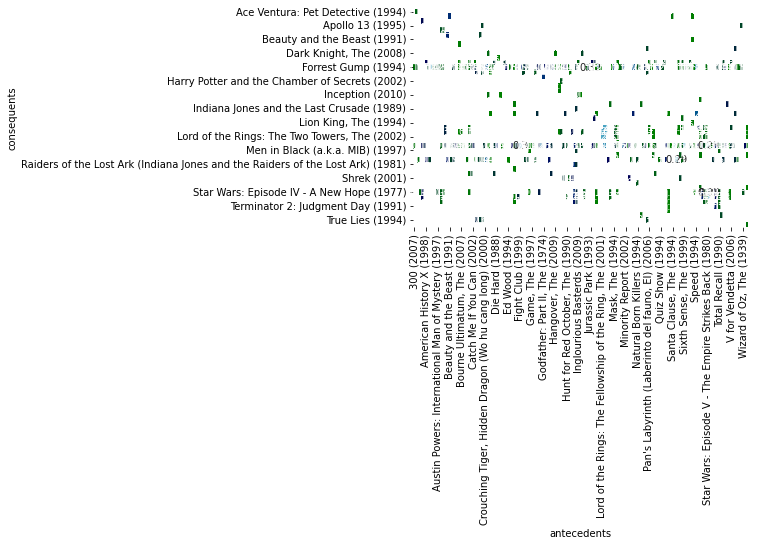

In [64]:
import seaborn as sns

frequent_itemsets = apriori(
    onehot, min_support=.1, use_colnames=True, max_len=2
)
rules = association_rules(frequent_itemsets)

rules['antecedents'] = rules['antecedents'].apply(lambda a: ",".join(list(a)))
rules['consequents'] = rules['consequents'].apply(lambda a: ",".join(list(a)))
# print(rules[['antecedents', 'consequents']])

support_table = rules.pivot(
    index = "consequents",
    columns = "antecedents",
    values = "support"
)
# sns.heatmap(support_table)
sns.heatmap(support_table, annot=True, cbar=False, cmap='ocean')

### Scatterplots
- Value 쌍을 나타낸다
  - (Antecedent, consequent) support
  - Confidence and lift
- 가정된 모델이 없고, 추세선이나 곡선도 필요없음
- Pruning을 위한 시작점을 제공한다

/usr/local/lib/python3.7/dist-packages/google/colab/_event_manager.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


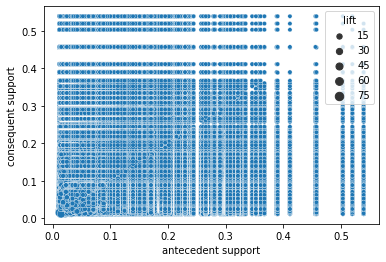

In [69]:
# frequent_itemsets = apriori(
#     onehot, min_support=.01, use_colnames=True, max_len=2
# )
# rules = association_rules(frequent_itemsets, metric='support', min_threshold=.0)
sns.scatterplot(
    x = "antecedent support",
    y = "consequent support",
    size = "lift",
    data = rules
)

### Parallel coordinates plot
vs. heatmap
- Intensity 정보가 필요없다
- Rule의 존재 여부만 알기 원할 때
- Visual clutter (방해)를 줄이고 싶을 때

vs. scatterplot
- 개별적인 rule의 정보를 알고 싶을 때
- multiple metric과는 관련이 적음
- 최종 rule만 관심 있을 때

In [76]:
frequent_itemsets = apriori(onehot, min_support=.1,
                             use_colnames=True, max_len=2)
rules = association_rules(frequent_itemsets, metric="support",
                          min_threshold=.0)

rules['antecedents'] = rules['antecedents'].apply(lambda a: list(a)[0])
rules['consequents'] = rules['consequents'].apply(lambda a: list(a)[0])
rules['rule'] = rules.index

coords = rules[['antecedents', 'consequents', 'rule']]
display(coords.head(1))

,antecedents,consequents,rule
0,2001: A Space Odyssey (1968),Alien (1979),0


In [ ]:
from pandas.plotting import parallel_coordinates

frequent_itemsets = apriori(onehot, min_support=.01,
                             use_colnames=True, max_len=2)
rules = association_rules(frequent_itemsets, metric="lift",
                          min_threshold=1.0)

rules['antecedents'] = rules['antecedents'].apply(lambda a: list(a)[0])
rules['consequents'] = rules['consequents'].apply(lambda a: list(a)[0])
rules['rule'] = rules.index

coords = rules[['antecedents', 'consequents', 'rule']]
parallel_coordinates(coords, "rule")